# Creating a PINN to simulation 2D incompressible Navier-Stokes

We will taken training data from OpenFOAM tutorial.

In [331]:
import numpy as np
import matplotlib.pyplot as plt
import Ofpp as ofpp
import matplotlib.animation as animation
import os
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [351]:
#Read in key parameters from control dict eventually
start_time = 0
end_time = 5
dt = 0.005
ofoam_write_interval = 1
ofoam_output_inc = dt * ofoam_write_interval
ofoam_num_outputs = ( end_time / ofoam_output_inc ) + 1

openfoam_case_path = "/Users/harry/openfoam/cavity-re100/"

x_start = 0
x_end = 1
y_start = 0
y_end = 1
numx = 20
numy = 20
numt = len(np.arange(start_time,end_time + ofoam_output_inc,ofoam_output_inc))
shape = (numt,numx,numy)
print(f"OpenFOAM data shape: {shape}")

print(f"Start: {start_time} end: {end_time}")
print(f"dt: {dt} num timesteps: {numt}")
print(f"Write interval: {ofoam_write_interval} ofoam_num_outputs: {ofoam_num_outputs}")
#print(f"Animation interval: {} animation images: {}")

#MIGHT NEED TO FIX THIS WITH IJ INDEXINGß
X, Y = np.meshgrid(
    np.linspace(x_start,x_end,numx),
    np.linspace(y_start,y_end,numy), indexing="ij")

u_full = np.empty(shape)
v_full = np.empty(shape)
w_full = np.empty(shape)
p_full = np.empty(shape)

openfoam_outputs = os.listdir(openfoam_case_path)
openfoam_outputs.remove("constant")
openfoam_outputs.remove("system")
openfoam_outputs.remove("0_orig")
openfoam_outputs.sort()
openfoam_outputs = openfoam_outputs[::ofoam_write_interval]

idx = 0
for time in openfoam_outputs:
    openfoam_timestep = openfoam_case_path + time
    if time == "0":
        u_full[idx,:,:] = 0
        u_full[idx,0,:] = 1
        
        v_full[idx,:,:] = 0
        
        p_full[idx,:,:] = 0
    else:
        U = ofpp.parse_internal_field(f"{openfoam_timestep}/U")
        u_full[idx,:,:] = U[:,0].reshape((numx,numy))
        v_full[idx,:,:] = U[:,1].reshape((numx,numy))
        
        p_full[idx,:,:] = ofpp.parse_internal_field(f"{openfoam_timestep}/p").reshape((numx,numy))
    
    idx += 1


OpenFOAM data shape: (1001, 20, 20)
Start: 0 end: 5
dt: 0.005 num timesteps: 1001
Write interval: 1 ofoam_num_outputs: 1001.0


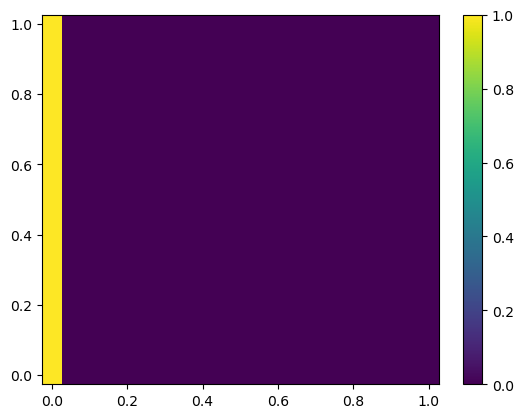

In [352]:
fig, ax = plt.subplots()
fig.colorbar(ax.pcolormesh(X, Y, u_full[0,:,:], shading='gouraud'), orientation='vertical')
ax.pcolormesh(X,Y,u_full[0,:,:])
plt.show()

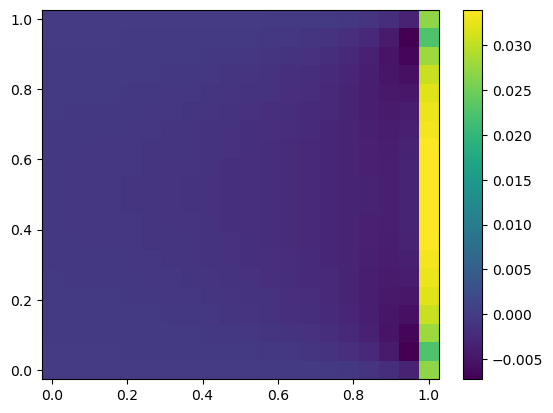

In [353]:
fig, ax = plt.subplots()
fig.colorbar(ax.pcolormesh(X, Y, u_full[1,:,:], shading='gouraud'), orientation='vertical')
ax.pcolormesh(X,Y,u_full[1,:,:])
plt.show()

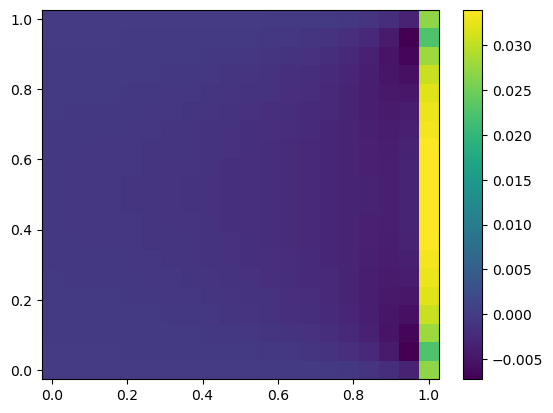

In [357]:
fig, ax = plt.subplots()
fig.colorbar(ax.pcolormesh(X, Y, np.flip(u_full[1,:,:]), shading='gouraud'), orientation='vertical')
ax.pcolormesh(X,Y,u_full[1,:,:])
plt.show()

In [345]:
u_full[1,:,0]

array([-4.96519e-05, -1.48964e-04, -2.46210e-04, -3.37289e-04,
       -4.19736e-04, -4.91523e-04, -5.50960e-04, -5.96694e-04,
       -6.27732e-04, -6.43422e-04, -6.43412e-04, -6.27703e-04,
       -5.96662e-04, -5.50927e-04, -4.91461e-04, -4.19662e-04,
       -3.37264e-04, -2.46222e-04, -1.48957e-04, -4.95815e-05])

In [343]:
u_full[1,0,:]

array([-4.96519e-05, -5.28083e-05, -5.54619e-05, -5.96272e-05,
       -6.54678e-05, -7.31973e-05, -8.31540e-05, -9.58599e-05,
       -1.12093e-04, -1.33019e-04, -1.60464e-04, -1.97428e-04,
       -2.49090e-04, -3.25002e-04, -4.44241e-04, -6.48179e-04,
       -1.03531e-03, -1.85747e-03, -3.32592e-03,  2.70316e-02])

In [288]:
#Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [289]:
t, y, x = np.meshgrid(
    np.linspace(start_time,end_time+dt,numt), #z direction
    np.linspace(y_start,y_end,numy), # rows
    np.linspace(x_start,x_end,numx), indexing='ij') #cols

print(x.shape)

features = np.concatenate((x.flatten().reshape(-1,1),y.flatten().reshape(-1,1),t.flatten().reshape(-1,1)), axis=1)
print(features.shape)

(1001, 20, 20)
(400400, 3)


In [290]:
#check out first 5 features
features[0:5,:]

array([[0.        , 0.        , 0.        ],
       [0.05263158, 0.        , 0.        ],
       [0.10526316, 0.        , 0.        ],
       [0.15789474, 0.        , 0.        ],
       [0.21052632, 0.        , 0.        ]])

In [291]:
features[20:20+5,:]

array([[0.        , 0.05263158, 0.        ],
       [0.05263158, 0.05263158, 0.        ],
       [0.10526316, 0.05263158, 0.        ],
       [0.15789474, 0.05263158, 0.        ],
       [0.21052632, 0.05263158, 0.        ]])

In [292]:
features[400:400+5,:]

array([[0.        , 0.        , 0.005005  ],
       [0.05263158, 0.        , 0.005005  ],
       [0.10526316, 0.        , 0.005005  ],
       [0.15789474, 0.        , 0.005005  ],
       [0.21052632, 0.        , 0.005005  ]])

OK, so we have our features x,y and t locations.

Now we need to extract our labels ensuring that the arrays are reshaped the same way as the features arrays.

In [325]:
u_full[0,:,:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0.

In [157]:
#Extract boundary locations
x_bound1 = x[:,1:,0::x.shape[1]-1] 
y_bound1 = y[:,1:,0::y.shape[1]-1] 
t_bound1 = t[:,1:,0::t.shape[1]-1] 

x_bound2 = x[:,-1,1:-1]
y_bound2 = y[:,-1,1:-1]
t_bound2 = t[:,-1,1:-1]

x_bound = np.hstack((x_bound1.ravel(),x_bound2.ravel()))
y_bound = np.hstack((y_bound1.ravel(),y_bound2.ravel()))
t_bound = np.hstack((t_bound1.ravel(),t_bound2.ravel()))

features_bound = np.vstack([x_bound, y_bound, t_bound])
features_bound[:,0:3]

array([[0.05263158, 0.05263158, 0.05263158],
       [0.        , 0.        , 0.        ],
       [0.        , 0.095     , 0.19      ]])

In [180]:
a[0,:,:]

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [181]:
a[:,1:,0::a.shape[1]-1] #left and right boundary condition excluding initial condition at top


array([[[ 3,  5],
        [ 6,  8]],

       [[12, 14],
        [15, 17]]])

In [182]:
a[:,-1,1:-1] #bottom boundary excluding left and right as they are captured in left and right boundary

array([[ 7],
       [16]])

In [183]:
#Concatenate boundary values into single array
boundaries = np.hstack((a[:,1:,0::a.shape[1]-1].ravel(),a[:,-1,1:-1].ravel()))
boundaries

array([ 3,  5,  6,  8, 12, 14, 15, 17,  7, 16])

In [184]:
#Now do the same with the features array


In [178]:
#Data wrangling to get 1D tensors for X,Y,t,u,v,p for interior and boundary conditions
#Convert to correct format
#Scaling
#Train-test split
#QC of train-test split
#Define NN structure
#Train network
#QC prediction

In [185]:
# Define MLP model architecture class
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        """_summary_
        """
        super().__init__()
        self.linear_stack = torch.nn.Sequential(
            torch.nn.Linear(3, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3)
        )

    def forward(self, x, y, t):
        """_summary_

        Args:
            x (_type_): _description_
            t (_type_): _description_

        Returns:
            _type_: _description_
        """
        inputs = torch.cat([x,y,t], axis=1).to(device)
        return self.linear_stack(inputs)

In [186]:
#Training loop

In [187]:
#Testing loop

In [188]:
#Loss function

In [189]:
#Main function

In [190]:
#QC plot and GIF using NN to predict fluid flow